# Census Income

# Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)).

The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state. Controls for Hispanic Origin by age and sex.
Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

# Importing necessary libraries

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as stats

from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve 

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Importing the DataSet

In [101]:
df=pd.read_csv(r'census_income.csv')

In [102]:
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In the dataset we have both categorical and numerical data.
There are two unique values in the target column <= 50K and >50K. We can say that whether the person has annual income <=50K or >50K.

The target variable 'Income' has two classes of data, hence its a classification data. We will look more into the dataset in the Exploratory Data Analysis part

# Exploratory Data Analysis

In [104]:
#check the size of the dataset

df.shape

(32560, 15)

We see that we have 32560 rows and 15 columns, out of which 1 (Income) is the targer or label

In [105]:
# Overview of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


This analysis shows that the datset has both object and integer datatypes. We will look into the datatypes and treat it accordingly.

In [106]:
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

We can see that there is no null values in the dataset

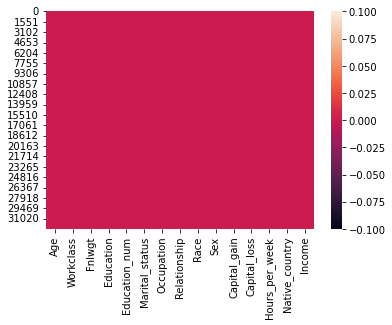

In [107]:
sns.heatmap(df.isnull())

plt.show()

We can clearly see no null values

In [108]:
#Check the number of unique values in each columns

df.nunique().to_frame('Number of Unique Values')

,Number of Unique Values
Age,73
Workclass,9
Fnlwgt,21647
Education,16
Education_num,16
Marital_status,7
Occupation,15
Relationship,6
Race,5
Sex,2


We can see here the number of unique values in each columns

In [109]:
# different datatypes of columns 

df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

We see data with object datatype and int datatype. We Will encode the object type later.

# Feature Engineering

In [110]:
#Check the value counts of each of the columns
for i in df.columns:
    print('-----------------------------------','\n')
    print(df[i].value_counts())

----------------------------------- 

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: Age, Length: 73, dtype: int64
----------------------------------- 

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
----------------------------------- 

164190    13
203488    13
123011    13
148995    12
126675    12
          ..
325573     1
140176     1
318264     1
329205     1
257302     1
Name: Fnlwgt, Length: 21647, dtype: int64
----------------------------------- 

 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th          

From aboves we see the following points

We have 29849 zero value in capital gain and 31041 zero values in capital loss, which is approximately 90% of the data, so we consider dropping them.

Also we have ? value in workclass, occupation and Native_country, so we need to impute this value.

In [111]:
# drop capital gains and capital loss columns

df.drop('Capital_gain', axis = 1, inplace = True)

df.drop('Capital_loss', axis = 1, inplace = True)

In [112]:
# imputing null values by most occuring value as these are categorical column

df['Workclass'] = df.Workclass.str.replace('?', 'Private')

df['Occupation'] = df.Occupation.str.replace('?', 'Prof-specialty')

df['Native_country'] = df.Native_country.str.replace('?', 'United-States')

In [113]:
df['Workclass'].value_counts()

 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

In [114]:
df['Occupation'].value_counts()

 Prof-specialty       5983
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3769
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

In [115]:
df['Native_country'].value_counts()

 United-States                 29752
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 France                           29
 

Now we have filled the data

Her we can see that there are multiple classes. Grouping related classes to one class and create new classes for easy analysis and visualization.

In [116]:
df.Workclass = df.Workclass.replace([' Local-gov',' State-gov',' Federal-gov'],' Govt-Sector')

df.Workclass = df.Workclass.replace([' Private',' Self-emp-not-inc',' Self-emp-inc'],' Pvt-sector')

df.Workclass = df.Workclass.replace([' Without-pay',' Never-worked'],'Not-working')

In [117]:
df['Workclass'].value_counts()

 Pvt-sector     28189
 Govt-Sector     4350
Not-working        21
Name: Workclass, dtype: int64

In [118]:
df['Education'] = df['Education'].replace([' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',' 12th'],'School')
df['Education'] = df["Education"].replace([' HS-grad',' Prof-school'],' High-School')
df['Education'] = df["Education"].replace([' Some-college',' Assoc-voc',' Assoc-acdm'],' Secondary-School')
df['Education'] = df["Education"].replace([' Bachelors',],' Under_Graduation')
df['Education'] = df["Education"].replace([' Masters'],'Post_Graduation')
df['Education'] = df["Education"].replace([' Doctorate'],' PhD')

In [119]:
df['Education'].value_counts()

 High-School         11077
 Secondary-School     9740
 Under_Graduation     5354
School                4253
Post_Graduation       1723
 PhD                   413
Name: Education, dtype: int64

In [120]:
df['Marital_status'] = df['Marital_status'].replace([' Married-civ-spouse',' Married-AF-spouse'],' Married')
df['Marital_status'] = df['Marital_status'].replace([' Never-married'],' Single')
df['Marital_status'] = df['Marital_status'].replace([' Divorced',' Widowed',' Separated',' Married-spouse-absent',],' Others')

In [121]:
df['Marital_status'].value_counts()

 Married    14999
 Single     10682
 Others      6879
Name: Marital_status, dtype: int64

In [122]:
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country,Income
0,50,Pvt-sector,83311,Under_Graduation,13,Married,Exec-managerial,Husband,White,Male,13,United-States,<=50K
1,38,Pvt-sector,215646,High-School,9,Others,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
2,53,Pvt-sector,234721,School,7,Married,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
3,28,Pvt-sector,338409,Under_Graduation,13,Married,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K
4,37,Pvt-sector,284582,Post_Graduation,14,Married,Exec-managerial,Wife,White,Female,40,United-States,<=50K


In [123]:
# Getting the value count of the target variable

df['Income'].value_counts()

 <=50K    24719
 >50K      7841
Name: Income, dtype: int64

We see that there are 2 classes, and the dataset is imbalanced. We will have to balance the datset for modelling.

# Statistical Analysis of the DataSet

In [125]:
# description of numerical data columns

df.describe()

,Age,Fnlwgt,Education_num,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,40.437469
std,13.640642,1.055498e+05,2.572709,12.347618
min,17.000000,1.228500e+04,1.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99.000000


This gives the statistical information of the dataset. The dataset looks perfect since there are no negative / invalid values present.

# Checking the 'categorical' and 'numerical columns'

In [126]:
# check the categorical columns

cat_col = []
for i in df.dtypes.index:
    if df.dtypes[i] == 'object':
        cat_col.append(i)

print(cat_col)

['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']


In [127]:
# check the numerical column

num_col=[]
for i in df.dtypes.index:
    if df.dtypes[i]!='object':
        num_col.append(i)

print(num_col)

['Age', 'Fnlwgt', 'Education_num', 'Hours_per_week']


# Data Visualization

# Univariate Analysis (Categorical columns)

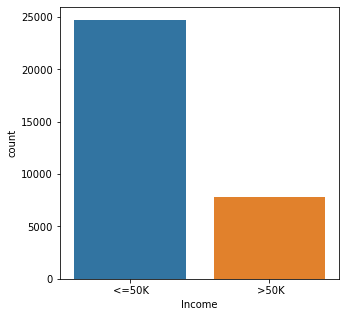

In [128]:
# Chekc whether the income is above 50K or not

plt.figure(figsize = (5,5))

sns.countplot(df['Income'])

plt.show()

we can clearly see that target is imbalanced and we will have to balance it

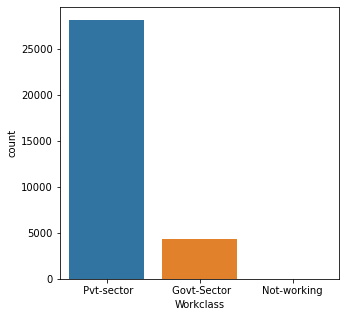

In [129]:
# Visualizing the column workclass

plt.figure(figsize = (5, 5))

sns.countplot(df['Workclass'])

plt.show()

Here we can see that, the population is max working in the private sector, followed by govt sector and none unemployed.

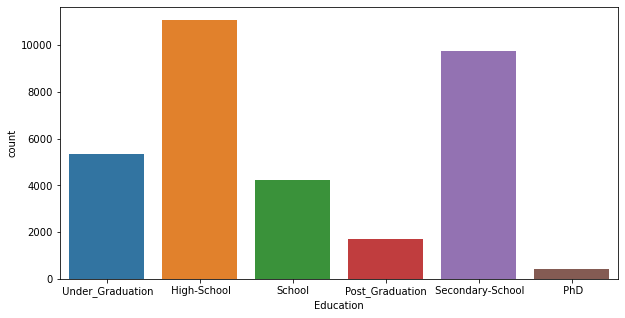

In [130]:
# Visualizing the Education column

plt.figure(figsize = (10, 5))

sns.countplot(df['Education'])

plt.show()

Here we can see that the max population has the education level at high school, followed by secondary school

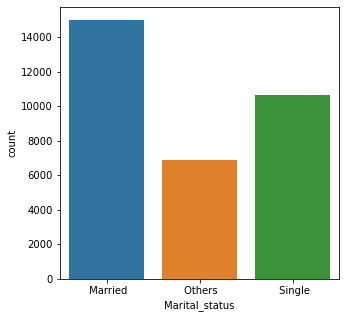

In [131]:
# Visualizing the Marital_status

plt.figure(figsize = (5,5))

sns.countplot(df['Marital_status'])

plt.show()

Here we can see that the population of married people are higher

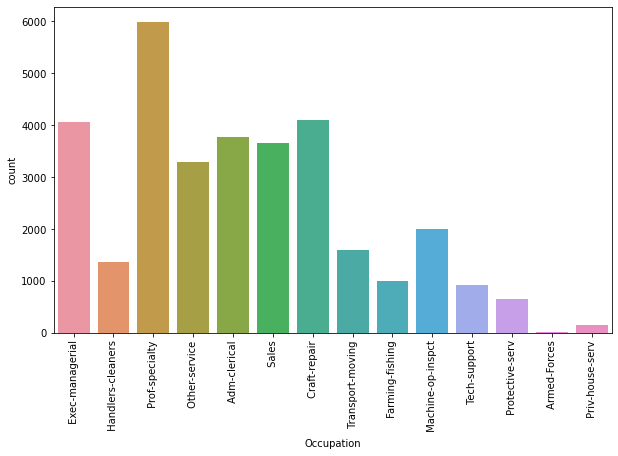

In [132]:
# Visualize the count of Occupation of the people

plt.figure(figsize = (10, 6))

sns.countplot(df['Occupation'])

plt.xticks(rotation = 90)

plt.show()

The people who are in the position of Prof-speciality have highest count and the people in the position Armed-Forces have very least counts

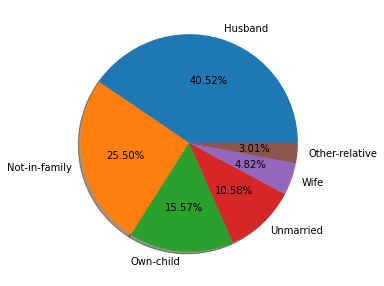

In [134]:
# Visualize the count of Relationship of the people

labels='Husband','Not-in-family','Own-child', 'Unmarried','Wife','Other-relative'

fig, ax = plt.subplots(figsize = (5, 5))

ax.pie(df['Relationship'].value_counts(), labels = labels, autopct = '%1.2f%%', shadow = True)

plt.show()

The count is high in the Husband category which has around 40% of count and other relative has very least count around 3%.

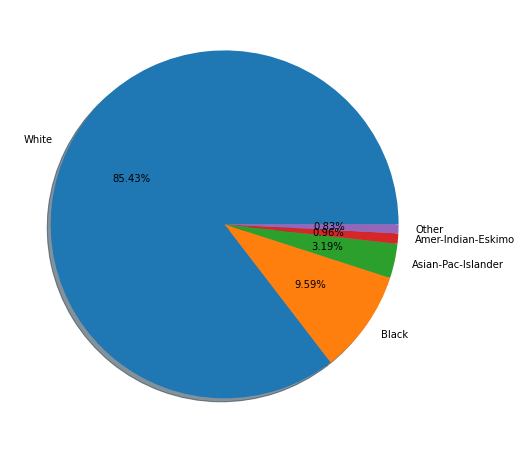

In [136]:
# count of Race of the people

labels = 'White','Black','Asian-Pac-Islander', 'Amer-Indian-Eskimo','Other'

fig, ax = plt.subplots(figsize = (10, 8))

ax.pie(df['Race'].value_counts(), labels = labels, autopct = '%1.2f%%', shadow = True)

plt.show()

White family groups have high count of around 85% and Other race have least count around 0.83%.

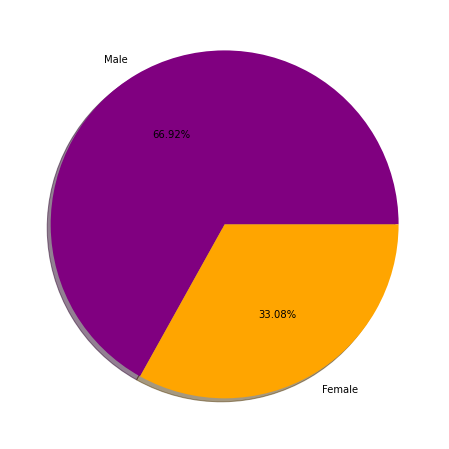

In [137]:
# count of Sex group of the people

labels = 'Male','Female'

fig, ax = plt.subplots(figsize = (10, 8))

colors = ['purple','orange']

ax.pie(df['Sex'].value_counts(), labels = labels, autopct = '%1.2f%%', shadow = True, colors = colors)

plt.show()

The count of Male is high and has around 67% and only 33% of females are there.

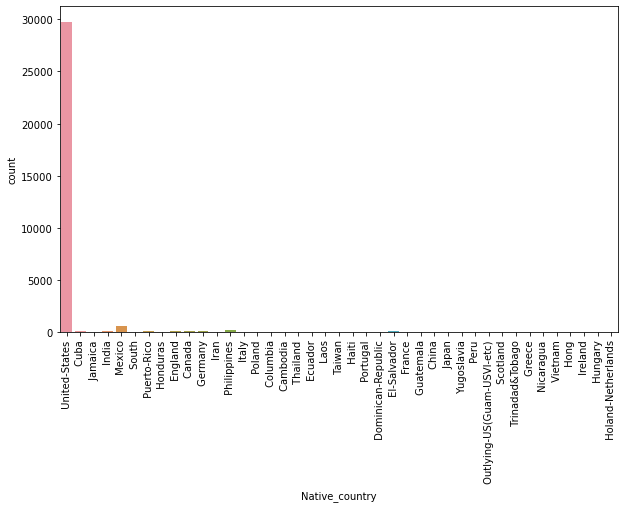

In [138]:
# Native country of the people

plt.figure(figsize = (10, 6))

sns.countplot(df['Native_country'])

plt.xticks(rotation = 90)

plt.show()

The United States country has highest count of around 29K and other countries have very less counts.

# Checking how the data is distributed (numerical columns)

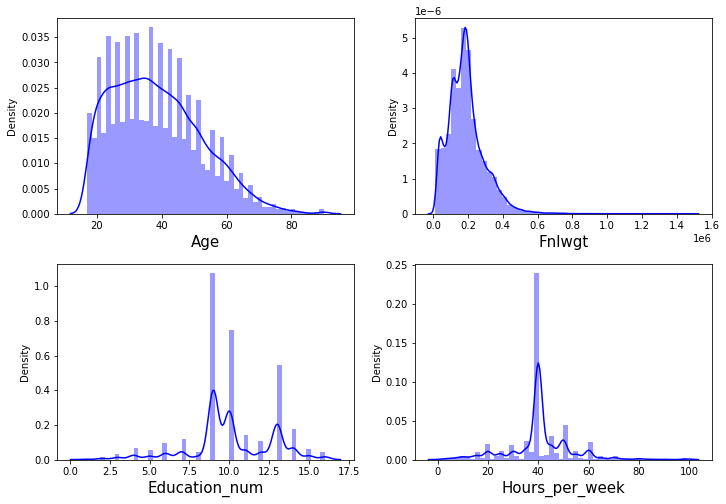

In [139]:
plt.figure(figsize = (10,10), facecolor = 'white')

plotnumber = 1

for columns in num_col:
    if plotnumber <= 5:
        ax = plt.subplot(3, 2, plotnumber)
        sns.distplot(df[columns], color = 'blue')
        plt.xlabel(columns, fontsize = 15)
    plotnumber += 1
plt.tight_layout()

We can clearly see that the dataset is not normal. We have 'Age', Final weight skewed right, education is scattered and hours is also scattered with no skewness

# Bivariate Analysis (Checking relation between features and label)# 

In [140]:
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Hours_per_week', 'Native_country', 'Income'],
      dtype='object')

<AxesSubplot:title={'center':'Comparision of Age and Income'}, xlabel='Age', ylabel='Income'>

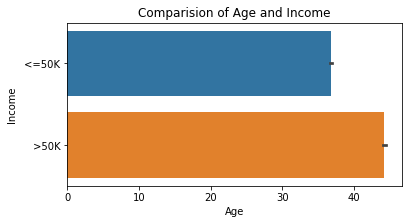

In [141]:
# Check the relation between target Income and variable Age

plt.figure(figsize = [6, 3])

plt.title('Comparision of Age and Income')

sns.barplot(df['Age'], df['Income'])

The older age group has income more then 50K

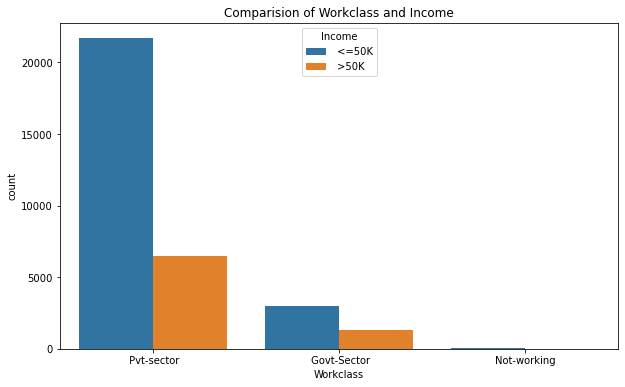

In [142]:
#Checking the relation between target Income and variable Workclass

plt.figure(figsize = (10, 6))

sns.countplot(df['Workclass'], hue = df['Income'])

plt.title('Comparision of Workclass and Income')

plt.show()

The people working in the private sectors have income <=50K and only few people in the same sector have income >50K. Also the people who never worked have no income.

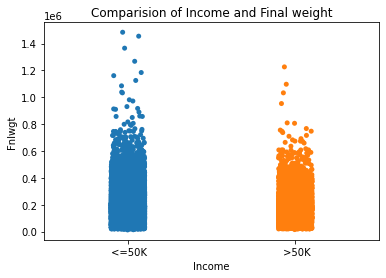

In [143]:
# Final weight with income

sns.stripplot(df['Income'], df['Fnlwgt'], data = df)

plt.title('Comparision of Income and Final weight')

plt.show()

There is no significant relation between final weight and income of the people.

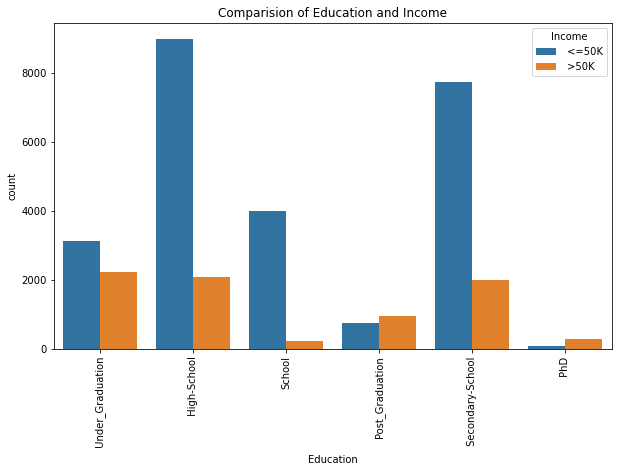

In [144]:
# The relation between Education and Income

plt.figure(figsize = (10, 6))

sns.countplot(df['Education'], hue = df['Income'])

plt.title('Comparision of Education and Income')

plt.xticks(rotation = 90)

plt.show()

The people who completed their high school have income <=50K followed by the people who done their Secondary School. Also the people who done their Graduation they are earning income >50K.

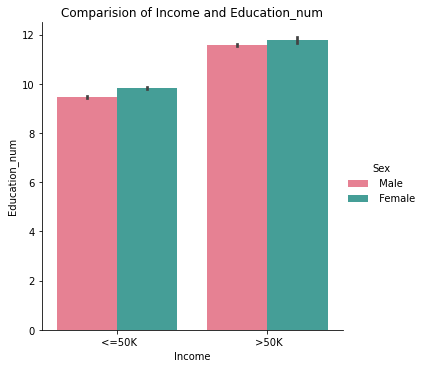

In [145]:
# The number of education_num with income

sns.catplot(x = 'Income', y = 'Education_num', data = df, kind = 'bar', hue = 'Sex', palette = 'husl')

plt.title('Comparision of Income and Education_num')

plt.show()

The Income is more than 50K for the people having high education number. Here both gender have the income more than 50K.

<Figure size 72x216 with 0 Axes>

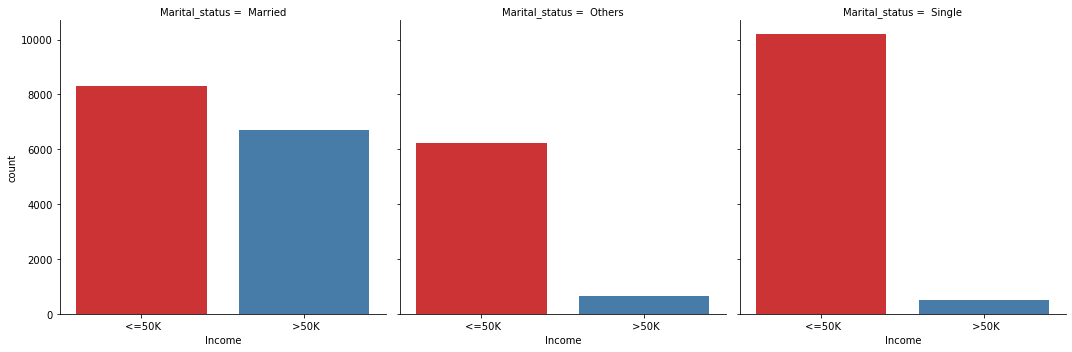

In [146]:
# Visualizing the relation between Marital status and Income

plt.figure(figsize = (1, 3))

sns.catplot(x = 'Income', col = 'Marital_status', data = df, kind = 'count', palette = 'Set1')

plt.show()

Married population have income >50K compare to others.

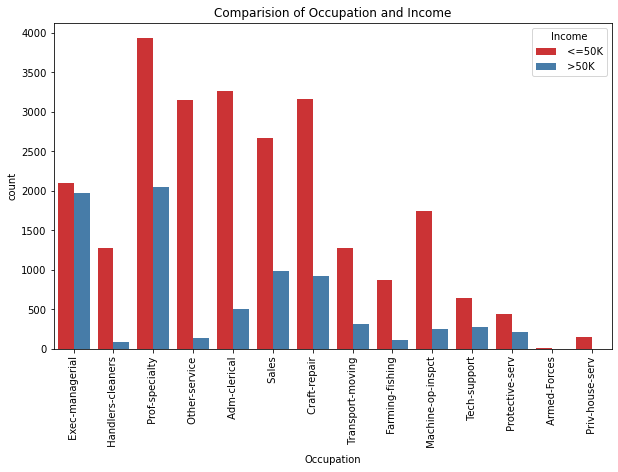

In [148]:
# The relation between Occupation and Income

plt.figure(figsize = (10, 6))

sns.countplot(df['Occupation'], hue = df['Income'], palette = 'Set1')

plt.title('Comparision of Occupation and Income')

plt.xticks(rotation = 90)

plt.show()

Population belonging to Prof-speciality and Exce-managerial have the income more than 50K.

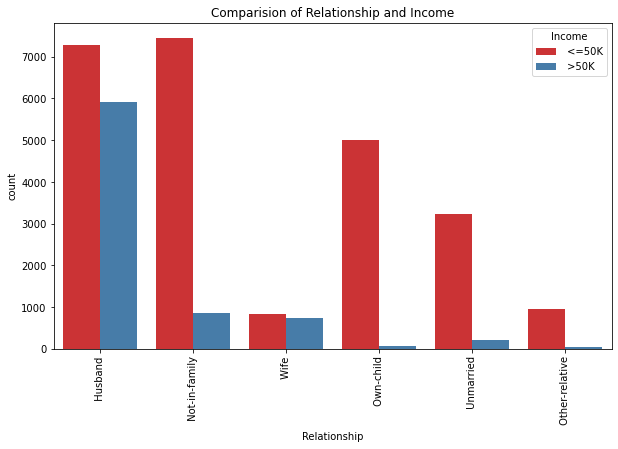

In [152]:
# The relation between Relationship and Income

plt.figure(figsize = (10, 6))

sns.countplot(df['Relationship'], hue = df['Income'], data = df, palette = 'Set1')

plt.title('Comparision of Relationship and Income')

plt.xticks(rotation = 90)

plt.show()

Population in relationship as Husband have relatively higher income

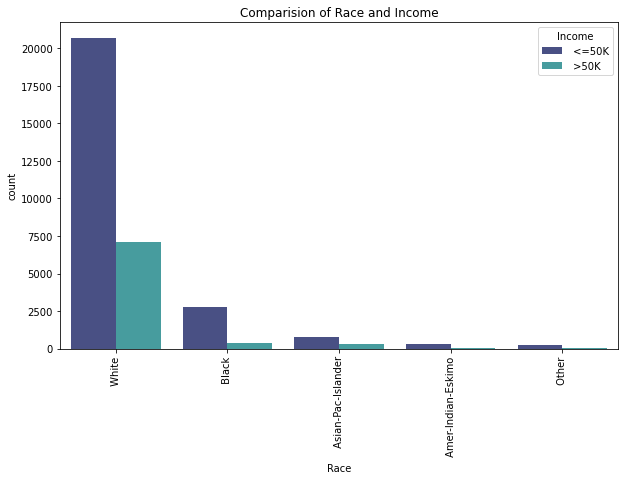

In [154]:
# The relation between Race and Income

plt.figure(figsize = (10, 6))

sns.countplot(df['Race'], hue = df['Income'], data = df, palette = 'mako')

plt.title('Comparision of Race and Income')

plt.xticks(rotation = 90)

plt.show()

The white family groups have high income >50K compare to other groups.

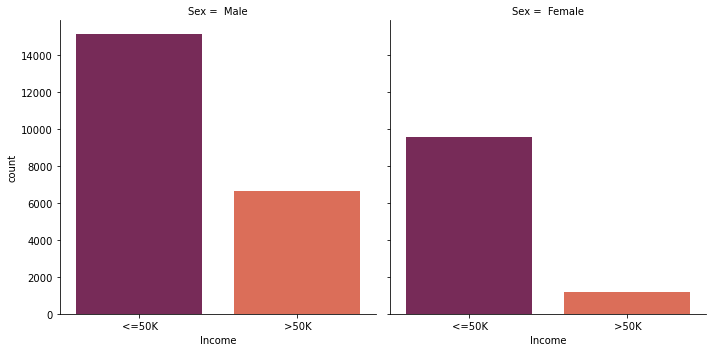

In [155]:
# The relation between Income and Sex groups

sns.catplot(x = 'Income', col = 'Sex', data = df, kind = 'count', palette = 'rocket')

plt.show()

The income of Male is above 50K compared to the female.

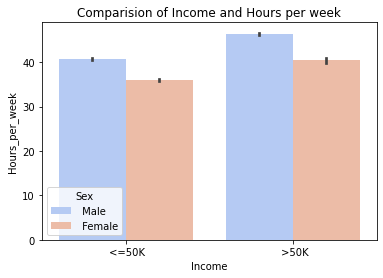

In [158]:
# The number of Hours per week with income

sns.barplot(x = 'Income', y = 'Hours_per_week', data = df, hue = "Sex", palette = 'coolwarm');

plt.title('Comparision of Income and Hours per week')

plt.show()

This shows how the income is related to the hours per week. The income is >50K when the Hours is high for both male and female.

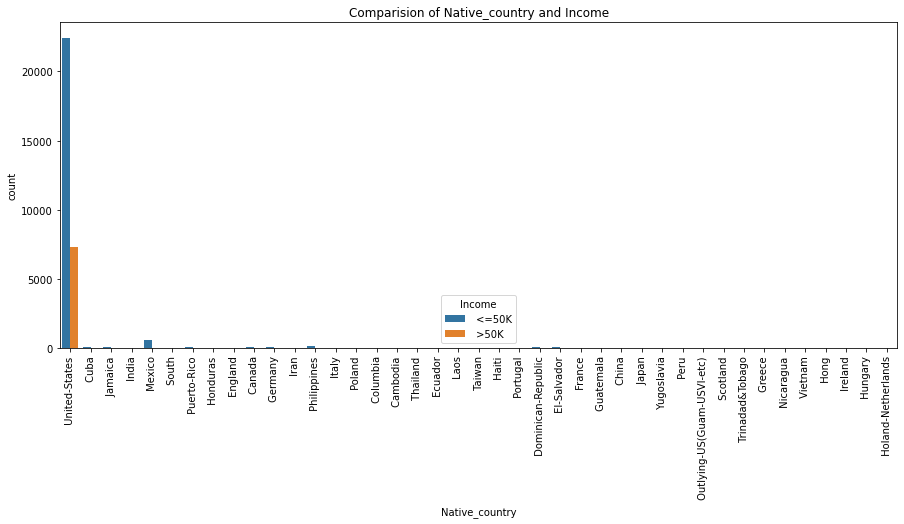

In [159]:
# Visualizing the relation between Native country and Income

plt.figure(figsize = (15, 6))

sns.countplot(df['Native_country'], hue = df['Income'] )

plt.title('Comparision of Native_country and Income')

plt.xticks(rotation = 90)

plt.show()

Clearly United States earns more income compared to all the other countries.

# Identifying the outliers

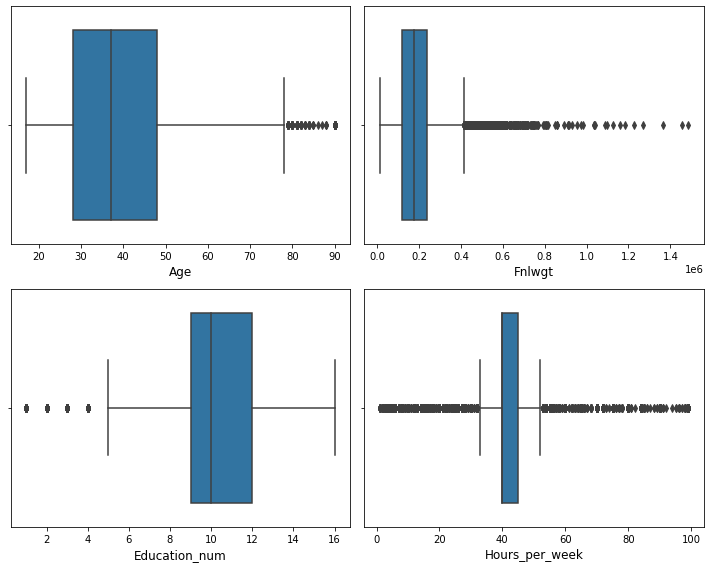

In [160]:
# Identifying the outliers using boxplot

plt.figure(figsize = (10, 8), facecolor = 'white')

plotnumber = 1

for column in num_col:
    if plotnumber <= 4:
        ax = plt.subplot(2, 2, plotnumber)
        sns.boxplot(df[column])
        plt.xlabel(column, fontsize = 12)
    plotnumber += 1
plt.tight_layout()

There are outliers present in all the columns. We will remove it using Zscore method.

# Removing outliers

In [161]:
features = df[['Age', 'Fnlwgt', 'Education_num', 'Hours_per_week']]

z = np.abs(zscore(features))

z

,Age,Fnlwgt,Education_num,Hours_per_week
0,0.837097,1.008742,1.134779,2.222120
1,0.042640,0.245046,0.420027,0.035430
2,1.057031,0.425770,1.197429,0.035430
3,0.775755,1.408146,1.134779,0.035430
4,0.115952,0.898170,1.523480,0.035430
...,...,...,...,...
32555,0.849066,0.639710,0.746077,0.197407
32556,0.103982,0.335466,0.420027,0.035430
32557,1.423589,0.358811,0.420027,0.035430
32558,1.215624,0.110927,0.420027,1.655200


In [162]:
# Creating new dataframe

new_df = df[(z<3).all(axis = 1)] 

new_df

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country,Income
0,50,Pvt-sector,83311,Under_Graduation,13,Married,Exec-managerial,Husband,White,Male,13,United-States,<=50K
1,38,Pvt-sector,215646,High-School,9,Others,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
2,53,Pvt-sector,234721,School,7,Married,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
3,28,Pvt-sector,338409,Under_Graduation,13,Married,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K
4,37,Pvt-sector,284582,Post_Graduation,14,Married,Exec-managerial,Wife,White,Female,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Pvt-sector,257302,Secondary-School,12,Married,Tech-support,Wife,White,Female,38,United-States,<=50K
32556,40,Pvt-sector,154374,High-School,9,Married,Machine-op-inspct,Husband,White,Male,40,United-States,>50K
32557,58,Pvt-sector,151910,High-School,9,Others,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K
32558,22,Pvt-sector,201490,High-School,9,Single,Adm-clerical,Own-child,White,Male,20,United-States,<=50K


In [163]:
df.shape

(32560, 13)

In [164]:
new_df.shape

(31461, 13)

# Checking the skewness of the dataset

In [165]:
new_df.skew().sort_values()

Hours_per_week   -0.341724
Education_num    -0.159752
Age               0.472279
Fnlwgt            0.634828
dtype: float64

There is skewness only in the Final Weight column

# Removig the skewness

In [166]:
new_df['Fnlwgt'] = np.cbrt(df['Fnlwgt'])

In [167]:
new_df.skew().sort_values()

Fnlwgt           -0.376609
Hours_per_week   -0.341724
Education_num    -0.159752
Age               0.472279
dtype: float64

<AxesSubplot:xlabel='Fnlwgt', ylabel='Density'>

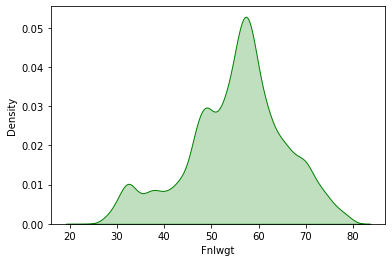

In [168]:
sns.distplot(new_df['Fnlwgt'], color = 'green', kde_kws = {'shade': True}, hist = False)

The data looks normalized then before

# Encoding the categorical columns using Label Encoding

In [170]:
categorical_col = ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']

LE = LabelEncoder()
new_df[categorical_col]= new_df[categorical_col].apply(LE.fit_transform)

In [171]:
new_df[categorical_col]

,Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
0,1,3,0,3,0,4,1,38,0
1,1,0,1,5,1,4,1,38,0
2,1,5,0,5,0,2,1,38,0
3,1,3,0,9,5,2,0,4,0
4,1,4,0,3,5,4,0,38,0
...,...,...,...,...,...,...,...,...,...
32555,1,2,0,12,5,4,0,38,0
32556,1,0,0,6,0,4,1,38,1
32557,1,0,1,0,4,4,0,38,0
32558,1,0,2,0,3,4,1,38,0


Categorical columns has been encoded and ready for modelling

# Checking Co-relation

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0, 0.5, 'Age'),
  Text(0, 1.5, 'Workclass'),
  Text(0, 2.5, 'Fnlwgt'),
  Text(0, 3.5, 'Education'),
  Text(0, 4.5, 'Education_num'),
  Text(0, 5.5, 'Marital_status'),
  Text(0, 6.5, 'Occupation'),
  Text(0, 7.5, 'Relationship'),
  Text(0, 8.5, 'Race'),
  Text(0, 9.5, 'Sex'),
  Text(0, 10.5, 'Hours_per_week'),
  Text(0, 11.5, 'Native_country'),
  Text(0, 12.5, 'Income')])

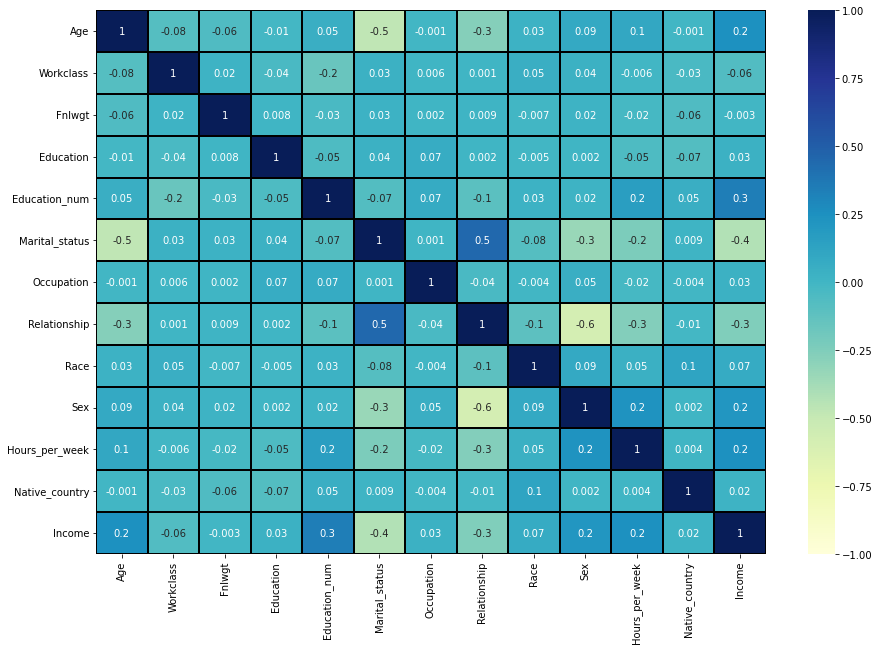

In [172]:
corr = new_df.corr()

plt.figure(figsize=(15, 10))

sns.heatmap(new_df.corr(), linewidths = 0.1, vmin = -1, vmax = 1, fmt = '.1g', annot = True, linecolor = 'black', annot_kws = {'size':10}, cmap = 'YlGnBu')

plt.yticks(rotation=0)

In [173]:
corr['Income'].sort_values(ascending = False)

Income            1.000000
Education_num     0.337595
Age               0.248351
Hours_per_week    0.242383
Sex               0.216665
Race              0.072451
Occupation        0.034612
Education         0.034278
Native_country    0.017698
Fnlwgt           -0.002780
Workclass        -0.062963
Relationship     -0.251506
Marital_status   -0.425904
Name: Income, dtype: float64

It is understandable from the heatmap and the table the relation between features and target. Also the positive and negative relationship can be seen.

# Seperating the features and target

In [174]:
x = new_df.drop('Income', axis = 1)

y = new_df['Income']

# Feature Scaling using Standard Scalarization

In [175]:
scaler = StandardScaler()

x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)

x

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country
0,0.875057,0.392103,-1.102052,0.621080,1.154324,-0.990371,-0.784335,-0.903178,0.391304,0.706601,-2.424121,0.254062
1,-0.025350,0.392103,0.464976,-1.149684,-0.459657,0.147158,-0.282327,-0.281938,0.391304,0.706601,-0.008364,0.254062
2,1.100158,0.392103,0.630260,1.801589,-1.266647,-0.990371,-0.282327,-0.903178,-1.969806,0.706601,-0.008364,0.254062
3,-0.775689,0.392103,1.399791,0.621080,1.154324,-0.990371,0.721690,2.203019,-1.969806,-1.415226,-0.008364,-5.457546
4,-0.100384,0.392103,1.023711,1.211335,1.557819,-0.990371,-0.784335,2.203019,0.391304,-1.415226,-0.008364,0.254062
...,...,...,...,...,...,...,...,...,...,...,...,...
31456,-0.850723,0.392103,0.814728,0.030825,0.750829,-0.990371,1.474703,2.203019,0.391304,-1.415226,-0.187309,0.254062
31457,0.124718,0.392103,-0.143169,-1.149684,-0.459657,-0.990371,-0.031323,-0.903178,0.391304,0.706601,-0.008364,0.254062
31458,1.475327,0.392103,-0.170768,-1.149684,-0.459657,0.147158,-1.537348,1.581780,0.391304,-1.415226,-0.008364,0.254062
31459,-1.225892,0.392103,0.335900,-1.149684,-0.459657,1.284688,-1.537348,0.960541,0.391304,0.706601,-1.797814,0.254062


As we have seen earlier that the target variable is imbalanced, lets balance it using SMOTE

# Oversampling (SMOTE)

In [178]:
SM = SMOTE()

x, y = SM.fit_resample(x,y)

In [179]:
y.value_counts()

0    23853
1    23853
Name: Income, dtype: int64

In [181]:
new_df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country,Income
0,50,1,43.675121,3,13,0,3,0,4,1,13,38,0
1,38,1,59.967204,0,9,1,5,1,4,1,40,38,0
2,53,1,61.685627,5,7,0,5,0,2,1,40,38,0
3,28,1,69.686283,3,13,0,9,5,2,0,40,4,0
4,37,1,65.776255,4,14,0,3,5,4,0,40,38,0


# Modelling to Find best random state

In [182]:
maxAccu = 0

maxRS = 0

for i in range(1,200):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = i)
    rfc = RandomForestClassifier()
    rfc.fit(x_train,y_train)
    pred = rfc.predict(x_test)
    acc = accuracy_score(y_test,pred)
    if acc > maxAccu:
        maxAccu = acc
        maxRS = i

print('Best accuracy of', maxAccu, 'on Random_state', maxRS)

Best accuracy of 0.8844326439351593 on Random_state 194


We got an accuracy score of 88.44% at a random state of 194

# Creating Train_Test_Split

In [183]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = maxRS)

# Logistic Regression

In [184]:
log = LogisticRegression()

log.fit(x_train,y_train)

predlog = log.predict(x_test)

print(accuracy_score(y_test, predlog))

print(confusion_matrix(y_test, predlog))

print(classification_report(y_test, predlog))

0.8019144773616546
[[5388 1713]
 [1122 6089]]
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      7101
           1       0.78      0.84      0.81      7211

    accuracy                           0.80     14312
   macro avg       0.80      0.80      0.80     14312
weighted avg       0.80      0.80      0.80     14312



We got an accuracy score of 80% with Logistic Regression

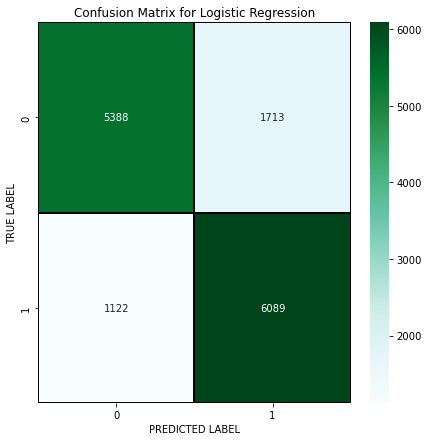

In [185]:
# Lets plot confusion matrix for DTC
cm = confusion_matrix(y_test,predlog)

x_axis_labels = ['0','1']

y_axis_labels = ['0','1']

f , ax = plt.subplots(figsize = (7,7))

sns.heatmap(cm, annot = True, linewidths = 0.2, linecolor = 'black', fmt = '.0f', ax = ax, cmap = 'BuGn', xticklabels =x_axis_labels, yticklabels = y_axis_labels)

plt.xlabel('PREDICTED LABEL')

plt.ylabel('TRUE LABEL')

plt.title('Confusion Matrix for Logistic Regression')

plt.show()

# Decision Tree Classifier

In [186]:
dtc = DecisionTreeClassifier()

dtc.fit(x_train,y_train)

preddtc = dtc.predict(x_test)

print(accuracy_score(y_test, preddtc))

print(confusion_matrix(y_test, preddtc))

print(classification_report(y_test,preddtc))

0.8350335382895472
[[5893 1208]
 [1153 6058]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      7101
           1       0.83      0.84      0.84      7211

    accuracy                           0.84     14312
   macro avg       0.84      0.83      0.84     14312
weighted avg       0.84      0.84      0.84     14312



We got an accuracy score of 84% with this model

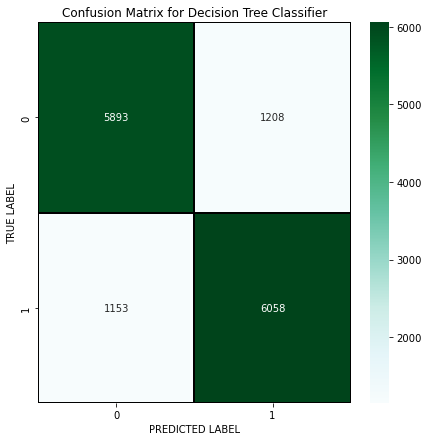

In [188]:
# Lets plot confusion matrix for DTC

cm = confusion_matrix(y_test, preddtc)

x_axis_labels = ["0","1"]

y_axis_labels = ["0","1"]

f , ax = plt.subplots(figsize=(7,7))

sns.heatmap(cm, annot = True, linewidths = 0.2, linecolor = 'black', fmt = '.0f', ax = ax, cmap = 'BuGn', xticklabels = x_axis_labels, yticklabels = y_axis_labels)

plt.xlabel('PREDICTED LABEL')

plt.ylabel('TRUE LABEL')

plt.title('Confusion Matrix for Decision Tree Classifier')

plt.show()

# Random Forest Classifier

In [189]:
rfc = RandomForestClassifier()

rfc.fit(x_train, y_train)

predrfc = rfc.predict(x_test)

print(accuracy_score(y_test, predrfc))

print(confusion_matrix(y_test, predrfc))

print(classification_report(y_test,predrfc))

0.8853409726103969
[[6175  926]
 [ 715 6496]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      7101
           1       0.88      0.90      0.89      7211

    accuracy                           0.89     14312
   macro avg       0.89      0.89      0.89     14312
weighted avg       0.89      0.89      0.89     14312



Getting an accuracy score of 89% with this model

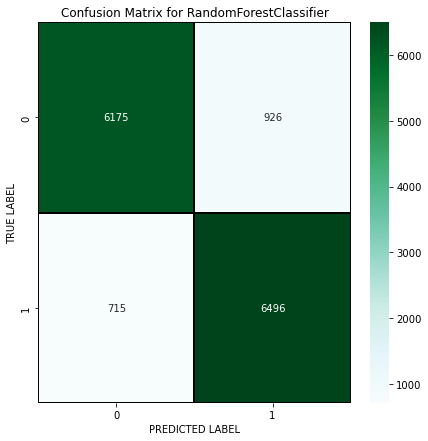

In [191]:
# Lets plot confusion matrix for RandomForestClassifier
cm = confusion_matrix(y_test,predrfc)

x_axis_labels = ['0','1']

y_axis_labels = ['0','1']

f , ax = plt.subplots(figsize = (7,7))

sns.heatmap(cm, annot = True, linewidths = 0.2, linecolor = 'black', fmt = '.0f', ax = ax, cmap = 'BuGn', xticklabels = x_axis_labels, yticklabels= y_axis_labels)

plt.xlabel('PREDICTED LABEL')

plt.ylabel('TRUE LABEL')

plt.title('Confusion Matrix for RandomForestClassifier')

plt.show()

# KNeighbors Classifier

In [192]:
# Checking accuracy for KNeighbors Classifier

knn = KNN()

knn.fit(x_train,y_train)

# Prediction
predknn = knn.predict(x_test)

print(accuracy_score(y_test, predknn))

print(confusion_matrix(y_test, predknn))

print(classification_report(y_test,predknn))

0.845653996646171
[[5469 1632]
 [ 577 6634]]
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      7101
           1       0.80      0.92      0.86      7211

    accuracy                           0.85     14312
   macro avg       0.85      0.85      0.84     14312
weighted avg       0.85      0.85      0.84     14312



Getting an accuacy score of 85% in this model

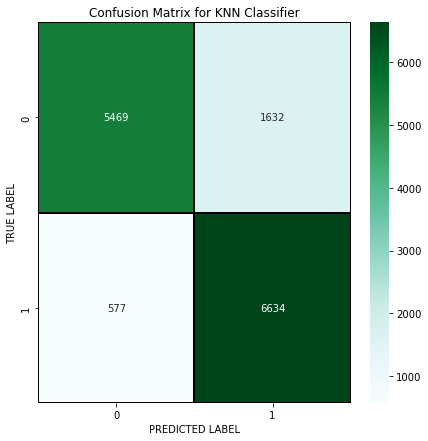

In [193]:
# Lets plot confusion matrix for KNN Classifier
cm = confusion_matrix(y_test,predknn)

x_axis_labels = ['0','1']

y_axis_labels = ['0','1']

f , ax = plt.subplots(figsize = (7,7))

sns.heatmap(cm, annot = True, linewidths = 0.2, linecolor = 'black', fmt = '.0f', ax = ax, cmap = 'BuGn', xticklabels = x_axis_labels, yticklabels = y_axis_labels)

plt.xlabel('PREDICTED LABEL')

plt.ylabel('TRUE LABEL')

plt.title('Confusion Matrix for KNN Classifier')

plt.show()

# Xtreme Gradient Boosting Classifier

In [194]:
# Check accuracy for XGBClassifier

from xgboost import XGBClassifier

xgb=XGBClassifier()

xgb.fit(x_train,y_train)

#Prediction
predxgb = xgb.predict(x_test)
print('Accuracy Score:', accuracy_score(y_test, predxgb))

print('Confusion Matrix:', confusion_matrix(y_test, predxgb))

print(classification_report(y_test,predxgb))

Accuracy Score: 0.8873672442705423
Confusion Matrix: [[6283  818]
 [ 794 6417]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      7101
           1       0.89      0.89      0.89      7211

    accuracy                           0.89     14312
   macro avg       0.89      0.89      0.89     14312
weighted avg       0.89      0.89      0.89     14312



Getting an accuracy score of 89% with this model

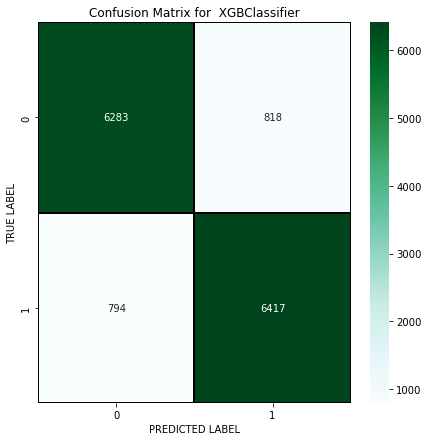

In [195]:
# Lets plot confusion matrix for  XGBClassifier
cm = confusion_matrix(y_test,predxgb)

x_axis_labels = ['0','1']

y_axis_labels = ['0','1']

f , ax = plt.subplots(figsize = (7,7))
sns.heatmap(cm, annot = True, linewidths = 0.2, linecolor = 'black', fmt = '.0f', ax = ax, cmap = 'BuGn', xticklabels = x_axis_labels, yticklabels = y_axis_labels)

plt.xlabel('PREDICTED LABEL')

plt.ylabel('TRUE LABEL')

plt.title('Confusion Matrix for  XGBClassifier')

plt.show()

# Checking the Cross Validation Score

In [196]:
# cv score for Logistic Regression Classifier
print(cross_val_score(log, x, y, cv = 5).mean())

# cv score for Decision Tree Classifier
print(cross_val_score(dtc, x, y, cv = 5).mean())

# cv score for Random Forest Classifier
print(cross_val_score(rfc, x, y, cv = 5).mean())

# cv score for KNN Classifier
print(cross_val_score(knn, x, y, cv = 5).mean())

# cv score for  XGBClassifier
print(cross_val_score(xgb, x, y, cv=5).mean())

0.7953508549221244
0.8308197490994695
0.8813581803436288
0.8490760336678441
0.8707108798570372


From the model accuracy and cross val accuracy score we see that 'RandomForestClassifier' is the best model

# Hyper Parameter Tuning

In [197]:
# Check Random Forest Classifier

parameters = {'criterion':['gini'],
             'max_features':['auto'],
             'n_estimators':[0,200],
             'max_depth':[2,3,4,5,6,8]}

In [198]:
GCV = GridSearchCV(RandomForestClassifier(), parameters, cv = 5)

In [199]:
GCV.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [2, 3, 4, 5, 6, 8],
                         'max_features': ['auto'], 'n_estimators': [0, 200]})

In [200]:
GCV.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [201]:
census = RandomForestClassifier (criterion = 'gini', max_depth = 8, max_features = 'auto', n_estimators = 200)
census.fit(x_train, y_train)
pred = census.predict(x_test)
acc=accuracy_score(y_test,pred)
print(acc*100)

83.89463387367245


The accuracy of the best model is increased after tuning and is giving 83.89% accuracy.

# Plotting ROC and Compare AUC for the best model

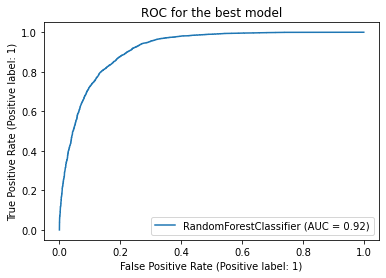

In [202]:
# Let's check the Auc for the best model after hyper parameter tuning

plot_roc_curve(census, x_test, y_test)

plt.title('ROC for the best model')

plt.show()

# Saving The Model

In [203]:
import joblib

joblib.dump(census,'Census_Income_Project.pkl')

['Census_Income_Project.pkl']